In [1]:
import json
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

figsize = (8,5)

pktPayloadSize = 1000. # Bytes
maxIntHdrSize = 52.
hpccHdrSize = 15.
ipHdrSize = 20.
mtu = pktPayloadSize + hpccHdrSize + maxIntHdrSize + ipHdrSize

torBw = 100e9 # bps
coreBw = 400e9 # bps

hostPerTor = 16.
torPerAgg = 4.
linkDelay = 1e-6 # seconds

timeLimit = 3.0 # only consider flows that finish before this

In [2]:
def remove_key(d, key):
    r = dict(d)
    del r[key]
    return r

In [3]:
def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [4]:
def compute_baseRtt(sender,receiver):
    sndIp = sender.split(':')[0]
    sndOctets = sndIp.split('.')
    sndIdx = int(sndOctets[1])*256 + int(sndOctets[2])
    sndTor = sndIdx // hostPerTor
    sndAggGrp = sndTor // torPerAgg
    
    rcvIp = receiver.split(':')[0]
    rcvOctets = rcvIp.split('.')
    rcvIdx = int(rcvOctets[1])*256 + int(rcvOctets[2])
    rcvTor = rcvIdx // hostPerTor
    rcvAggGrp = rcvTor // torPerAgg

    ackSize = ipHdrSize + hpccHdrSize + 2 * maxIntHdrSize
    delay = 4 * linkDelay + 2 * (mtu+ackSize) * 8 / torBw 
#     delay = 2 * linkDelay + 2 * (mtu) * 8 / torBw
    if (sndTor == rcvTor):
        return delay
    
    delay += 4 * linkDelay + 2 * (mtu+ackSize) * 8 / coreBw
#     delay += 2 * linkDelay + 2 * (mtu) * 8 / coreBw
    if (sndAggGrp == rcvAggGrp):
        return delay 

    delay += 4 * linkDelay + 2 * (mtu+ackSize) * 8 / coreBw
#     delay += 2 * linkDelay + 2 * (mtu) * 8 / coreBw
    return delay

In [5]:
def compute_slowDown(fct, baseRtt, msgSize):
    # translate to the minimum bytes required (with header but no INT)
    totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hpccHdrSize+ipHdrSize) 
    
    standaloneFct = baseRtt + totBytes * 8 / torBw;
    return max(fct / standaloneFct, 1.0)
    
#     baseCompletionTime = (totBytes+mtu)*8.0/torBw + 4*mtu*8.0/coreBw + 6*linkDelay
#     return max(fct / baseCompletionTime, 1.0)

In [6]:
workloadName = 'FbHdp'
networkLoad = 0.5
duration = 50 # milliseconds
simName = workloadName 
simName += 'L' + str(int(networkLoad*100)) + 'p'
simName += 'T' + str(int(duration)) + 'ms'
folderName = "./"
fileTag = "-180221" #"" #
step = 5

# Importing the Original NS3 Simulation Data

In [7]:
origFctAnalysisResults = """0.000 300	1.013 1.702 2.365
0.050 325	1.014 1.703 2.360
0.100 350	1.014 1.703 2.356
0.150 400	1.015 1.704 2.373
0.200 450	1.016 1.714 2.377
0.250 499	1.016 1.696 2.363
0.300 549	1.017 1.707 2.351
0.350 599	1.017 1.703 2.357
0.400 650	1.018 1.714 2.373
0.450 700	1.018 1.701 2.344
0.500 850	1.020 1.706 2.364
0.550 1002	1.022 1.712 2.376
0.600 1717	1.036 1.728 2.377
0.650 7217	1.065 1.770 2.416
0.700 36027	1.333 2.432 3.244
0.750 46041	1.451 2.746 3.704
0.800 68020	1.538 3.049 4.167
0.850 119994	1.705 3.634 5.127
0.900 299956	2.070 4.911 7.044
0.950 9999557	3.909 14.472 22.279"""

In [8]:
origMsgSizePctls = []
origMsgSizes = []
origMedSlowDowns = []
origSlowDowns95p = []
origSlowDowns99p = []
for line in origFctAnalysisResults.split('\n'):
    vals = line.split()
    origMsgSizePctls.append(float(vals[0]))
    origMsgSizes.append(int(vals[1]))
    origMedSlowDowns.append(float(vals[2]))
    origSlowDowns95p.append(float(vals[3]))
    origSlowDowns99p.append(float(vals[4]))

# Importing the NS3 NanoPuArcht Simulation Data

In [9]:
msgStartEntryDict = {}
zipData = []
unfoundMsgCnt = 0

with open(folderName+"FlowTraces"+simName+fileTag+".tr",'r') as f:
    for line in f:
        msgLog = line.split()

        time = float(msgLog[1])*1e-9        # in seconds
        msgSize = int(msgLog[2])            # in bytes
        sender = msgLog[3]                  # ip:port
        receiver = msgLog[4]                # ip:port
        txMsgId = int(msgLog[5])

        if (msgLog[0]=='+'):
            key = (sender, receiver, txMsgId)
            if (key in msgStartEntryDict):
                msgStartEntryDict[key].append(time)
            else:
                msgStartEntryDict[key] = [time]

        elif (msgLog[0] =='-' and time < timeLimit):
            key = (sender, receiver, txMsgId)
            if (key in msgStartEntryDict):
                          
                startTime = msgStartEntryDict[key].pop()
                if (len(msgStartEntryDict[key]) <= 0):
                    msgStartEntryDict = remove_key(msgStartEntryDict, key)

                baseRtt = compute_baseRtt(sender,receiver)
                
                zipData.append((msgSize,
                                compute_slowDown(time-startTime,
                                                 baseRtt,
                                                 msgSize)))
            else:
#                 print('ERROR: Start entry of message (' \
#                       + sender + ' > ' + receiver + ', ' + str(txMsgId) \
#                       + ') not found!')
                unfoundMsgCnt += 1

zipData = sorted(zipData)
nanopuMsgSizes = [x for x,_ in zipData]
nanopuSlowDowns = [x for _,x in zipData]

print ('Number of messages whoose start entry is not found: {}'.format(unfoundMsgCnt))

Number of messages whoose start entry is not found: 0


In [10]:
i = 0
for msgKey, msgStartTimes in msgStartEntryDict.items():
#     print(msgKey, ' : ', msgStartTimes)
    i += len(msgStartTimes)
print ('Number of uncompleted messages: ' + str(i))

Number of uncompleted messages: 0


In [11]:
res = [[i/100.] for i in range(0, 100, step)]
nMsgs = len(nanopuMsgSizes)
for i in range(0,100,step):
    l = int(i * nMsgs / 100)
    r = int((i+step) * nMsgs / 100)
    msOfThisStep = nanopuMsgSizes[l:r]
    sdOfThisStep = sorted(nanopuSlowDowns[l:r])
    res[int(i/step)].append(msOfThisStep[-1]) # flow size
    #res[int(i/step)].append(sum(sdOfThisStep) / len(sdOfThisStep)) # avg fct
    res[int(i/step)].append(get_pctl(sdOfThisStep, 0.5)) # mid fct
    res[int(i/step)].append(get_pctl(sdOfThisStep, 0.95)) # 95-pct fct
    res[int(i/step)].append(get_pctl(sdOfThisStep, 0.99)) # 99-pct fct
nanopuMsgSizePctls = [x for x,_,_,_,_ in res]
nanopuMsgSizes = [x for _,x,_,_,_ in res]
nanopuMedSlowDowns = [x for _,_,x,_,_ in res]
nanopuSlowDowns95p = [x for _,_,_,x,_ in res]
nanopuSlowDowns99p = [x for _,_,_,_,x in res]

In [12]:
res

[[0.0, 299, 1.0, 1.478919909291894, 2.331206457176634],
 [0.05, 324, 1.0, 1.4513746875796316, 2.236899343594947],
 [0.1, 349, 1.0, 1.4872291882159037, 2.3211352821776483],
 [0.15, 400, 1.0, 1.4814640541646187, 2.2518984877130874],
 [0.2, 449, 1.0, 1.4561437653889, 2.2942565726108026],
 [0.25, 500, 1.0, 1.4769587942963363, 2.26483138852977],
 [0.3, 550, 1.0, 1.4738819273784587, 2.2673193503543017],
 [0.35, 600, 1.0, 1.470898047559786, 2.2773307958452413],
 [0.4, 650, 1.0, 1.4712075466662242, 2.3158460618504804],
 [0.45, 701, 1.0, 1.478183562879781, 2.3041441079736433],
 [0.5, 851, 1.0, 1.4691502726085652, 2.313646510708274],
 [0.55, 1000, 1.0, 1.467084933332496, 2.289419077176215],
 [0.6, 1715, 1.0, 1.4916506397672478, 2.2439582014680934],
 [0.65, 7541, 1.0, 1.4796324433575256, 2.2608888522713038],
 [0.7, 36100, 1.0, 1.547112127265009, 2.162278106532705],
 [0.75, 46106, 1.0, 1.5660202155544938, 2.1336126676370286],
 [0.8, 68579, 1.0, 1.5906514931066618, 2.1401660646412477],
 [0.85, 1220

# Plotting the Slowdown Curves

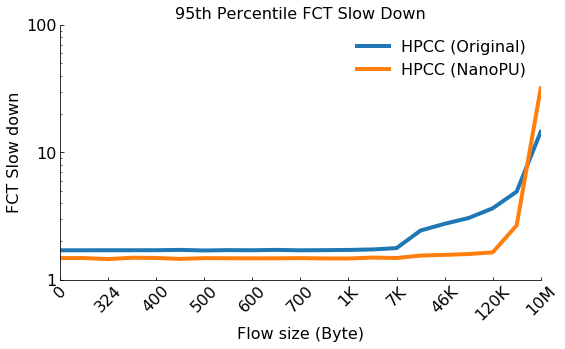

In [13]:
# plt.figure(figsize=(4,2.5))
plt.figure(figsize=figsize)
fontsize = 16

plt.plot(origMsgSizePctls+[1.0], 
         [origSlowDowns95p[0]]+origSlowDowns95p, 
         label='HPCC (Original)', linewidth=4.0)
plt.plot(nanopuMsgSizePctls+[1.0], 
         [nanopuSlowDowns95p[0]]+nanopuSlowDowns95p, 
         label='HPCC (NanoPU)', linewidth=4.0)

plt.yscale('log')
plt.ylim([1,100])
yticks = [1,10,100]
plt.yticks(yticks, yticks, fontsize=fontsize)
# plt.xticks(msgSizePctls, msgSizes, rotation=45)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
           ['0','324','400','500','600','700','1K','7K', '46K', '120K', '10M'], 
           rotation=45, fontsize=fontsize)
plt.xlim([0.0,1.0])

plt.title('95th Percentile FCT Slow Down', fontsize=fontsize)
plt.ylabel('FCT Slow down', fontsize=fontsize)
plt.xlabel('Flow size (Byte)', fontsize=fontsize)
plt.legend(frameon=False, fontsize=fontsize)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

plt.gca().tick_params(axis="both", which='both', direction="in", 
                      left=True, labelleft=True)

plt.savefig(folderName+"FlowTraces"+simName+fileTag+"-95pFctSlowDown.png")
plt.show()

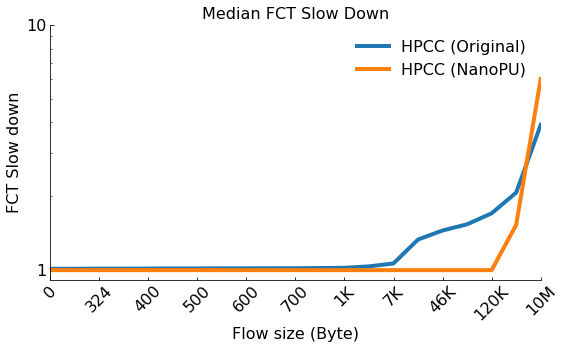

In [14]:
plt.figure(figsize=figsize)

plt.plot(origMsgSizePctls+[1.0], 
         [origMedSlowDowns[0]]+origMedSlowDowns, 
         label='HPCC (Original)', linewidth=4.0)
plt.plot(nanopuMsgSizePctls+[1.0], 
         [nanopuMedSlowDowns[0]]+nanopuMedSlowDowns, 
         label='HPCC (NanoPU)', linewidth=4.0)

plt.yscale('log')
# plt.ylim([1,100])
yticks = [1,10]
plt.yticks(yticks, yticks, fontsize=fontsize)
# plt.xticks(msgSizePctls, msgSizes, rotation=45)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
           ['0','324','400','500','600','700','1K','7K', '46K', '120K', '10M'], 
           rotation=45, fontsize=fontsize)
plt.xlim([0.0,1.0])

plt.title('Median FCT Slow Down', fontsize=fontsize)
plt.ylabel('FCT Slow down', fontsize=fontsize)
plt.xlabel('Flow size (Byte)', fontsize=fontsize)
plt.legend(frameon=False, fontsize=fontsize)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

plt.gca().tick_params(axis="both", which='both', direction="in", 
                      left=True, labelleft=True)

plt.show()

In [15]:
# The best results I got so far:
bestRes = """[[0.0, 299, 1.0, 1.4497321901595324, 2.278873386187758],
 [0.05, 324, 1.0, 1.4221423289500488, 2.1837662583428314],
 [0.1, 349, 1.0, 1.457147591752127, 2.273227021553373],
 [0.15, 400, 1.0, 1.4520676691624712, 2.1961711999682665],
 [0.2, 449, 1.0, 1.4277387421114291, 2.2454803735486997],
 [0.25, 500, 1.0, 1.4489857656952347, 2.2182273288954826],
 [0.3, 550, 1.0, 1.4449735483455666, 2.216221631228586],
 [0.35, 600, 1.0, 1.4417997836104837, 2.2229451312025494],
 [0.4, 650, 1.0, 1.4427908958946984, 2.26455672844174],
 [0.45, 701, 1.0, 1.4485967935517707, 2.2500306190563606],
 [0.5, 851, 1.0, 1.4412489883353599, 2.2588111118552523],
 [0.55, 1000, 1.0, 1.438215231954428, 2.2323979883451344],
 [0.6, 1715, 1.0, 1.4621428933231304, 2.1957843727127835],
 [0.65, 7541, 1.0, 1.451337595438713, 2.2129191956860774],
 [0.7, 36100, 1.0, 1.5213654928593874, 2.125345671119688],
 [0.75, 46106, 1.0, 1.5417130873688227, 2.098293445171721],
 [0.8, 68579, 1.0, 1.5681059108549265, 2.1111594753425966],
 [0.85, 122032, 1.0, 1.6194553340362976, 2.0554883285340755],
 [0.9, 309363, 1.5165522416714337, 2.6506895644604294, 4.794006236062708],
 [0.95, 9999988, 6.004538084568793, 31.740939544641645, 40.08192668469377]]"""